# Example script for fitting a King model to a cluster

In [1]:
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as units
from astropy.modeling import models, fitting

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2
from getGaiaData import GaiaClusterMembers

In [4]:
# reading from file
cluster = GaiaClusterMembers(12.108, 85.255, 1)
cluster.membershipMin = 0.01
cluster.readDataFromFile('NGC188_Gaia_r1deg.ecsv')
cluster.data

source_id,ra,dec,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_g_mean_flux_over_error,phot_bp_mean_mag,phot_bp_mean_flux_over_error,phot_rp_mean_mag,phot_rp_mean_flux_over_error,parallax,teff_gspphot,ruwe,number_of_neighbours,number_of_mates,g_mean_psf_mag,g_mean_psf_mag_error,r_mean_psf_mag,r_mean_psf_mag_error,i_mean_psf_mag,i_mean_psf_mag_error,z_mean_psf_mag,z_mean_psf_mag_error,y_mean_psf_mag,y_mean_psf_mag_error,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,phot_g_mean_mag_error,phot_bp_mean_mag_error,phot_rp_mean_mag_error,PRV,PPa,PPM,membership
,deg,deg,mas / yr,mas / yr,km / s,mag,,mag,,mag,,mas,K,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,
int64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,int16,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64
2300190316856449792,359.98750319791213,85.27731021181354,5.577777946544573,0.8223713177577376,--,19.63665,341.99533,20.002611,18.388771,19.328531,20.541069,-0.1341667036106458,--,0.94112283,1,0,20.0638008117676,0.0188410002738237,19.6161003112793,0.0171440001577139,19.4860992431641,0.0176279991865158,19.4738998413086,0.024957999587059,19.2819995880127,0.0314869992434978,--,--,--,--,--,--,0.0042036385,0.059109326,0.052991793,--,nan,0.0,0.0
2300190389873017344,359.98580433917704,85.29153336809398,-0.45119658435619325,-7.369807586160412,--,15.3995,3061.557,16.214743,423.20645,14.515954,665.11975,2.6719380963486183,4465.8047,1.0373826,1,0,16.5529003143311,0.00435000006109476,15.4191999435425,0.00275099999271333,14.9090995788574,0.00281400000676513,14.6612997055054,0.0038459999486804,14.5123996734619,0.00355900009162724,13.351,0.026,12.689,0.027,12.589,0.024,0.0027780489,0.0037903613,0.004116847,--,1.393492588159047e-14,0.0,0.0
2300194513040635392,359.9672581412721,85.35538913265248,-9.5544722428929,11.493419487214474,--,20.776224,104.699455,21.09304,5.081117,19.413204,11.7823105,0.2914078457257431,--,1.2037239,1,0,--,--,--,--,20.043399810791,0.0434660017490387,19.3617000579834,0.0285819992423058,19.0830993652344,0.0577099993824959,--,--,--,--,--,--,0.01072983,0.21369882,0.09222715,--,1.9210641383422348e-16,0.0,0.0
2300195539536739968,359.9561033834297,85.38657068886691,-3.6040957972934886,-4.830773107328921,--,19.797134,292.3895,20.890688,11.483998,18.660702,37.19538,1.6650491955322446,--,1.0105067,1,0,21.6236000061035,0.167224004864693,20.1315002441406,0.0238770004361868,19.0904006958008,0.0103240003809333,18.5962009429932,0.0114460000768304,18.3631000518799,0.0377160012722015,--,--,--,--,--,--,0.00462391,0.09458455,0.029433731,--,6.174760120055705e-11,0.0,0.0
2300195543833751936,359.93715165090276,85.39148265642352,-7.484505222627249,-1.0243014405359296,--,17.474413,1381.5422,18.050188,113.562935,16.749992,160.39871,0.45945903459236864,4855.8975,0.98020154,1,0,18.2007999420166,0.00268099992536008,17.4680004119873,0.00554100004956126,17.1201000213623,0.00322500010952353,16.9694995880127,0.00489299977198243,16.8798999786377,0.0127280000597239,15.859,0.079,15.547,0.127,15.157,0.138,0.0028652065,0.009959477,0.007752603,--,0.13324041474786458,0.0,0.0
573291861010519936,17.86475655428175,84.40895212731938,-3.1184996834597936,6.959047729898664,--,19.583765,309.9595,21.041176,6.721011,18.39454,41.02457,1.3949384522215436,--,0.975186,1,0,21.4948997497559,0.0286309998482466,20.2254009246826,0.0351330004632473,18.8167991638184,0.0133720003068447,18.1676006317139,0.00936200004070997,17.8712997436523,0.0117070004343987,16.453,0.115,15.657,0.116,15.62,0.204,0.0044566384,0.16156767,0.026734002,--,2.9527355739392034e-09,0.0,0.0
573291861010520576,17.916517386254274,84.40633591882035,1.7401034596752953,-2.190226773476811,--,17.22847,1246.6713,17.823576,83.66266,16.4942,238.91078,0.7474290084478957,4625.978,0.9977198,1,0,18.0048007965088,0.0119939995929599,17.2082996

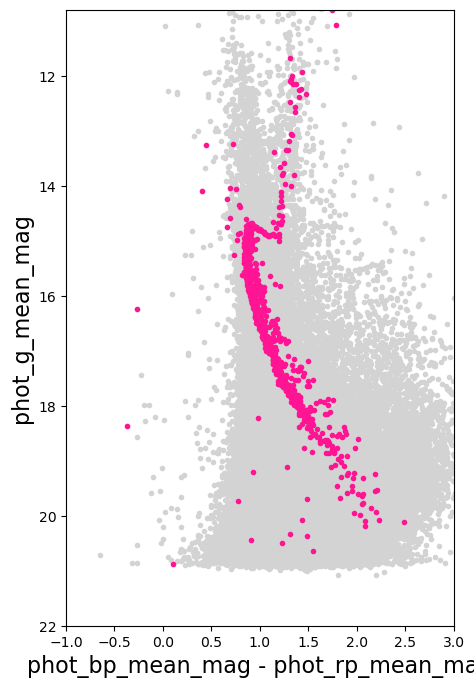

In [5]:
cluster.plotCMD(color1='phot_bp_mean_mag', color2='phot_rp_mean_mag', mag='phot_g_mean_mag')

In [23]:
# get the members
mask = (cluster.data['membership'] > cluster.membershipMin) 
members = cluster.data[mask]

# calcuate the distance from the cluster center (in arcmin)
#center = SkyCoord(cluster.RA*units.degree, cluster.Dec*units.degree, frame='icrs')

# or should we use the mean (or median) values of RA and Dec from the members??
center = SkyCoord(np.mean(members['ra'])*units.degree, np.mean(members['dec'])*units.degree, frame='icrs')

members['coord'] = SkyCoord(members['ra'], members['dec'], frame='icrs') 
members['rCenter'] = center.separation(members['coord']).to(units.arcmin)

Text(0, 0.5, 'N / arcmin$^2$')

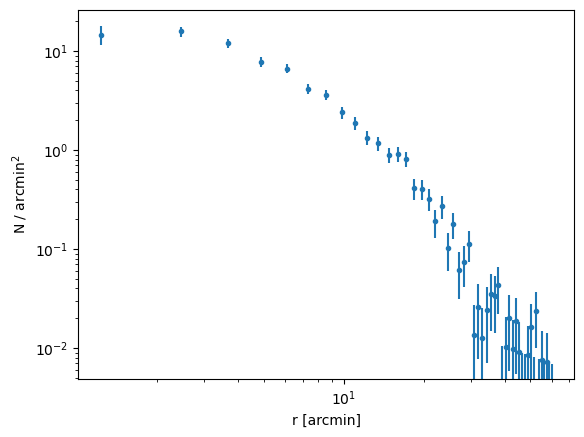

In [25]:
# get the histogram of radial values

# set the radial bins (in arcmin)
bins = np.linspace(0, 60, 50)

# calculate the bin centers
bin_centers = bins[:-1] + np.diff(bins)[0]

# get the radial histogram (number in each bin)
nr,br = np.histogram(members['rCenter'],bins = bins)

# calculate the surface areas
sarea = [bin_centers[0]**2.]
sarea += [bin_centers[i+1]**2. - bin_centers[i]**2. for i in range(len(bin_centers) - 1)]
sarea = np.array(sarea)

# calculate the surface density (N/area)
sdensity = nr/sarea

# calculate the uncertainty on the surface density (using propagation of errors and assuming zero uncertainty on the surface area)
err_sdensity = np.sqrt(nr)/sarea

# make sure that the errors are always non-zero (not sure the best approach here)
xx = np.where(err_sdensity == 0)
err_sdensity[xx] = 1./sarea[xx]

# plot
f,ax = plt.subplots()
_ = ax.errorbar(bin_centers, sdensity, yerr = err_sdensity, fmt = '.')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('r [arcmin]')
ax.set_ylabel(r'N / arcmin$^2$')

In [27]:
# fit a King model
p_init = models.KingProjectedAnalytic1D(max(sdensity), 2., 60.)
fit_p = cluster.fitter
king = fit_p(p_init, bin_centers, sdensity, weights = 1.0/err_sdensity)

# get the parameters and the uncertainties
# https://github.com/astropy/astropy/issues/7202
param_names = king.param_names
params = king.parameters
err_params = np.sqrt(np.diag(fit_p.fit_info['param_cov']))

print('fit parameters :')
for (x1,x2,x3) in zip(param_names, params, err_params):
    print(f'{x1} = {x2:.3} +/- {x3:.3}')

fit parameters :
amplitude = 24.4 +/- 1.94
r_core = 4.78 +/- 0.342
r_tide = 41.4 +/- 1.59


Text(0, 0.5, 'N / arcmin$^2$')

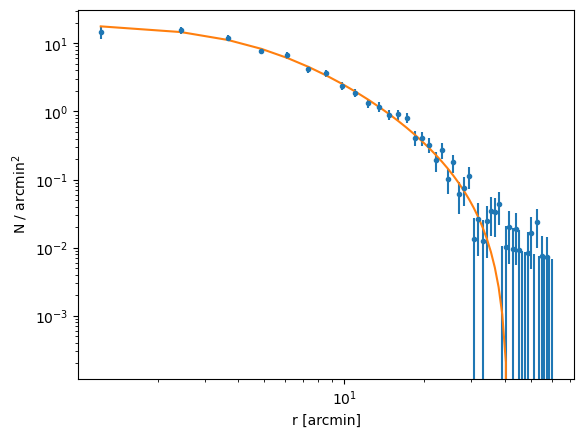

In [28]:
# plot with the king model fit
f,ax = plt.subplots()
_ = ax.errorbar(bin_centers, sdensity, yerr = err_sdensity, fmt = '.')
foo = models.KingProjectedAnalytic1D(*king.parameters)
ax.plot(bin_centers, foo(bin_centers))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('r [arcmin]')
ax.set_ylabel(r'N / arcmin$^2$')